In [1]:
# ML_in_Finance-Bayesian-Neural-Network
# Author: Matthew Dixon
# Version: 1.0 (24.7.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6.9 with the following packages:
# numpy=1.18.1, pymc3=3.8, theano=1.0.4, scikit-learn=0.22.1, seaborn=0.10.1, matplotlib=3.1.3
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., Halperin I. and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020.
# This notebook is adapted from a notebook written by Thomas Wiecki and Maxim Kochurov (2017):
# https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html?highlight=advi

### Overview

This notebook demonstrates the application of Bayesian Neural Networks to the half-moon problem. The notebook uses variation inference, implemented in PyMC3. Variational inference algorithms are faster than MCMC methods - the latter sample from the exact posterior distribution whereas the former sample from approximations such as ELBO. The advantage of the Bayesian approach is that it informs us about the uncertainty in its predictions. Another advantage is that Bayesion estimation is intrinsically self-regularizing through the choice of prior on the weights. In frequentist estimation, weights are often L2-regularized to avoid overfitting, this very naturally becomes a Gaussian prior for the weight coefficients. We could, however, imagine all kinds of other priors, like spike-and-slab to enforce sparsity (this would be more like using the L1-norm).


### Data generation
Generate data for a simple binary classification problem that's not linearly separable - the half-moon problem.

In [2]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
X, Y = make_moons(noise=0.0, random_state=0, n_samples=100)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.01)

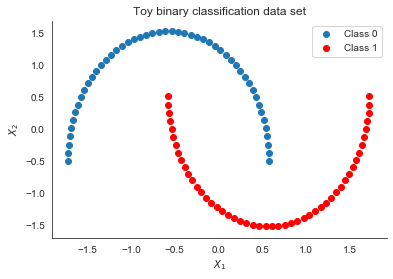

In [4]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='$X_1$', ylabel='$X_2$', title='Toy binary classification data set');

### Model specification
Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem. Std. Gaussian priors are specified for each weight.

In [5]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

### Variational Inference: Scaling model complexity

The following code uses [ADVI](http://pymc-devs.github.io/pymc3/api.html#advi),  a variational inference algorithm in `PyMC3`. Note, that this is a mean-field approximation so we ignore correlations in the posterior.

In [6]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [7]:
%%time
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

Average Loss = 54.727: 100%|██████████| 30000/30000 [00:27<00:00, 1075.38it/s]
Finished [100%]: Average Loss = 54.721


CPU times: user 20.7 s, sys: 4.33 s, total: 25 s
Wall time: 42.1 s


Plotting the objective function (ELBO) we can see that the optimization slowly improves the fit over time.

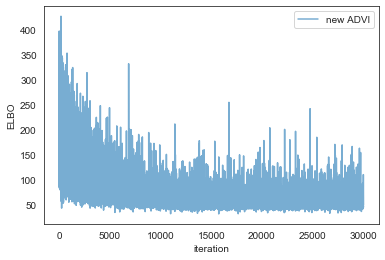

In [8]:
plt.plot(inference.hist, label='new ADVI', alpha=.6)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [9]:
trace = approx.sample(draws=5000)

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC).

We can use `sample_posterior_predictive() <../api/inference.rst>`__ to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).
It is faster to get the node directly and build the theano graph using our approximation (approx.sample_node).


In [10]:
# create symbolic input for lazy evaluation
x = T.matrix('X')

# symbolic number of samples is supported
n = T.iscalar('n')

# Do not forget test_value or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={neural_network['ann_input']: x})
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

In [11]:
sample_proba(X_test, 500)

array([[0.80802561],
       [0.82423778],
       [0.97994034],
       [0.89437593],
       [0.96353403],
       [0.88558896],
       [0.80331555],
       [0.4917701 ],
       [0.92810131],
       [0.98101766],
       [0.85624666],
       [0.85517597],
       [0.97255608],
       [0.74703665],
       [0.91666586],
       [0.83144164],
       [0.9686878 ],
       [0.97387003],
       [0.85255112],
       [0.9491301 ],
       [0.95165042],
       [0.73383528],
       [0.95322711],
       [0.92886253],
       [0.89627727],
       [0.83609473],
       [0.86959687],
       [0.55269719],
       [0.80196494],
       [0.87894589],
       [0.9199637 ],
       [0.53338788],
       [0.60014619],
       [0.80203418],
       [0.85040677],
       [0.28393491],
       [0.89945617],
       [0.88858664],
       [0.97743552],
       [0.93170101],
       [0.787288  ],
       [0.75564635],
       [0.9290125 ],
       [0.93360421],
       [0.56739512],
       [0.89796754],
       [0.93315238],
       [0.857

In [12]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

In [13]:
pred.shape

(1,)

In [14]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 100.0%


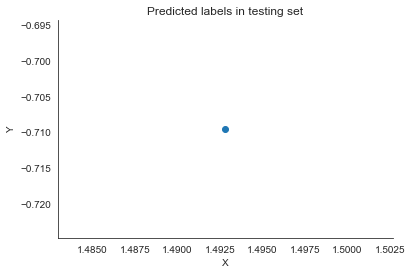

In [15]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==True, 0], X_test[pred==True, 1])
ax.scatter(X_test[pred==False, 0], X_test[pred==False, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [16]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [17]:
ppc = sample_proba(grid_2d ,500) 

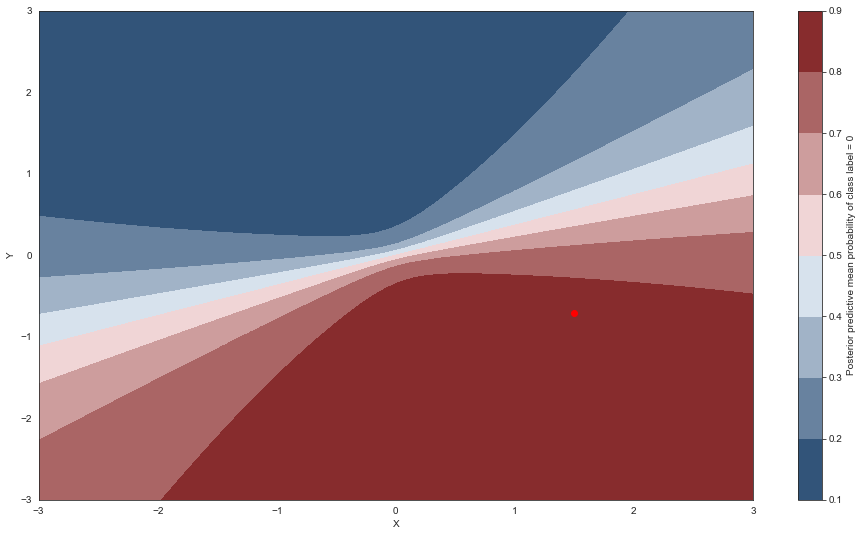

In [18]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

# Uncertainty in predicted value

The standard deviation of the posterior predictive characterizes the uncertainty in the predictions.



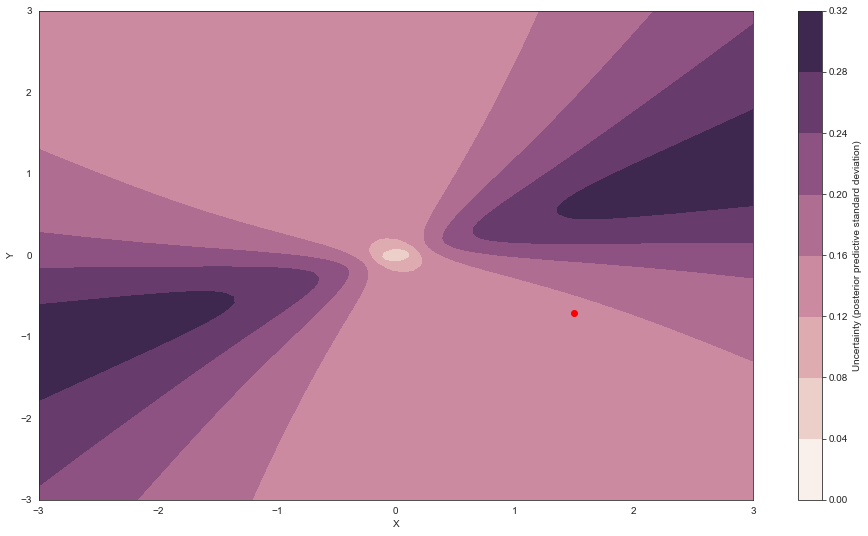

In [19]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

We can see that very close to the decision boundary, our uncertainty as to which label to predict is highest. To reduce uncertainty, we might want to train the model primarily on samples from that high-uncertainty region.

# Diagnostics 
Plot the posteriors of the Neural Network weights.

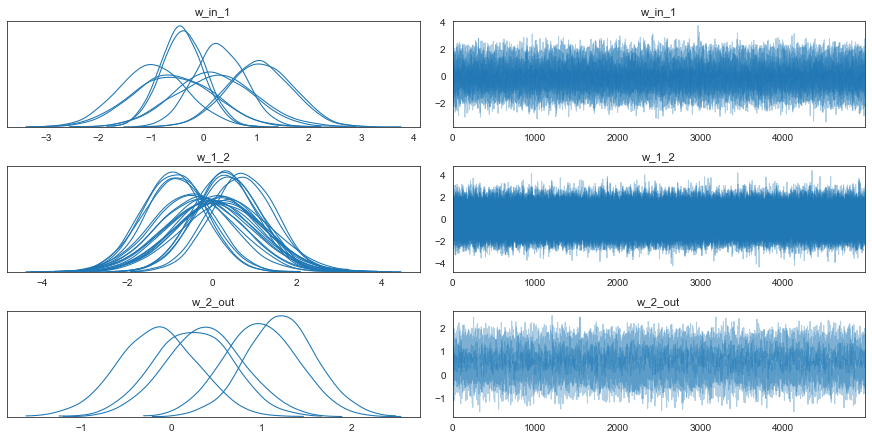

In [20]:
pm.traceplot(trace);